# YOLOv8 牙齿检测演示

单张图片的牙齿检测效果演示，显示真实标签 vs 模型预测对比。

- 绿色框 --> 真实标签
- 红色框 --> 模型预测

模型路径: ./outputs/dentalai/train_yolov8n_2ep_2025_08_14_09_14_07/weights/best.pt
图片路径: ./preprocessed_datasets/dentalai/test/images/1012_jpg.rf.8ed3d51db93a4be67e7083ed329c6039.jpg
所有文件存在，准备开始检测！
正在加载模型...
模型加载成功!
类别名称: ['Caries', 'Cavity', 'Crack', 'Tooth']

检测结果分析:
真实标签: 15 个
预测结果: 11 个
成功匹配: 6 个
漏检 (FN): 9 个
误检 (FP): 5 个

匹配详情:
   GT-1 (Caries) <-> Pred-10 (Caries, 0.36) | IoU: 0.689
   GT-5 (Tooth) <-> Pred-1 (Tooth, 1.00) | IoU: 0.940
   GT-6 (Tooth) <-> Pred-3 (Tooth, 0.98) | IoU: 0.951
   GT-9 (Caries) <-> Pred-6 (Caries, 0.46) | IoU: 0.760
   GT-10 (Tooth) <-> Pred-2 (Tooth, 0.99) | IoU: 0.971
   GT-14 (Caries) <-> Pred-5 (Caries, 0.54) | IoU: 0.708

检测结果分析:
真实标签: 15 个
预测结果: 11 个
成功匹配: 6 个
漏检 (FN): 9 个
误检 (FP): 5 个

匹配详情:
   GT-1 (Caries) <-> Pred-10 (Caries, 0.36) | IoU: 0.689
   GT-5 (Tooth) <-> Pred-1 (Tooth, 1.00) | IoU: 0.940
   GT-6 (Tooth) <-> Pred-3 (Tooth, 0.98) | IoU: 0.951
   GT-9 (Caries) <-> Pred-6 (Caries, 0.46) | IoU: 0.760
   GT-10 (Tooth) <-> Pred-2 (Tooth, 0.99)

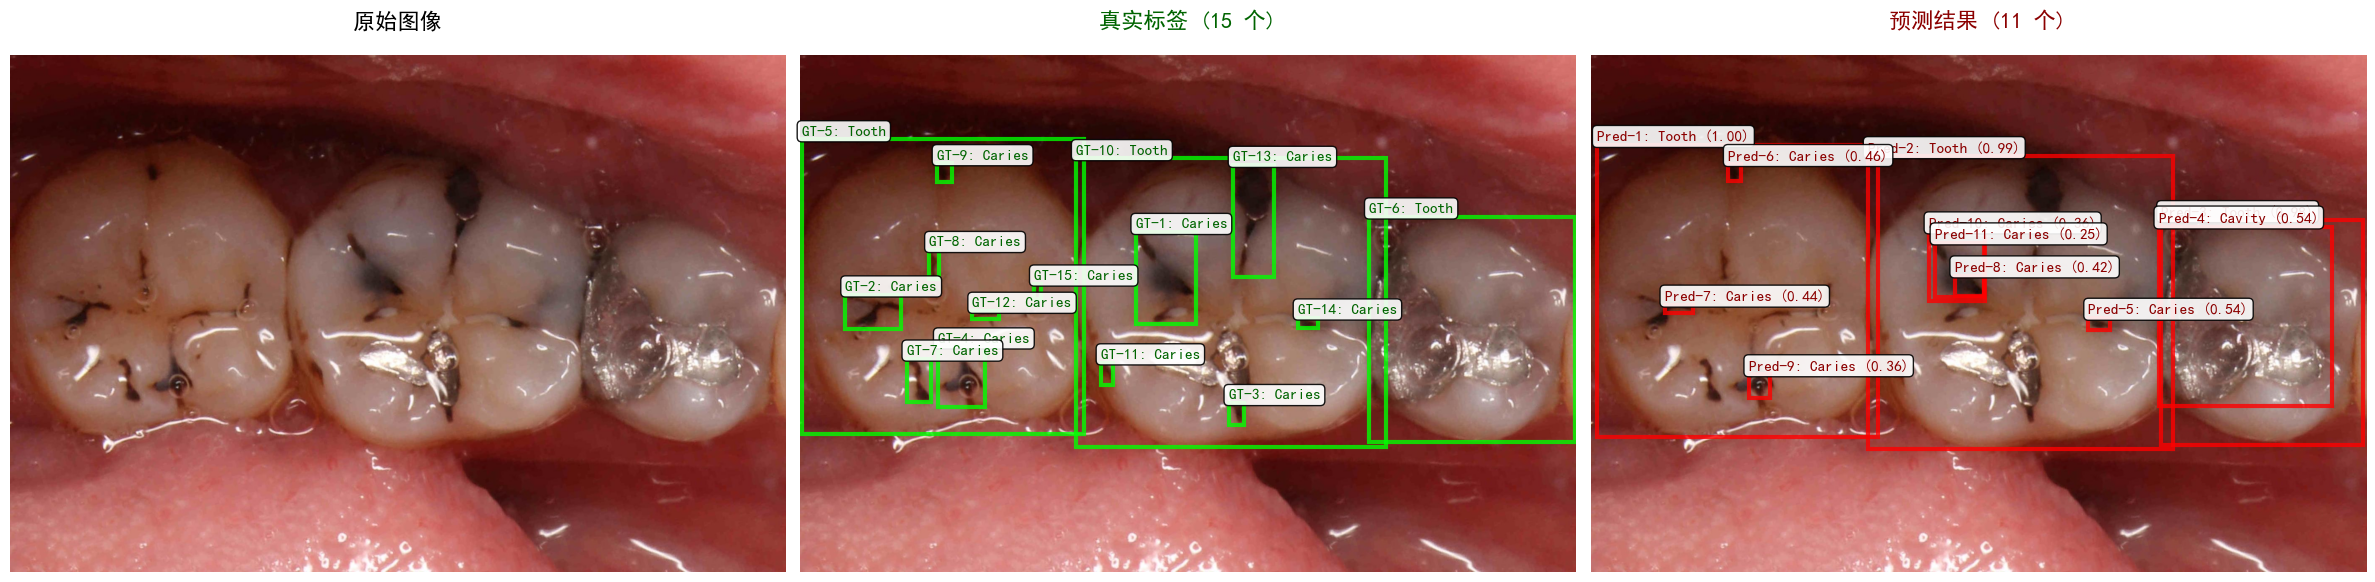

In [ ]:
# 配置参数

# 1. 训练好的模型路径
MODEL_PATH = "./outputs/dentalai/train_yolov8n_2ep_2025_08_14_09_14_07/weights/best.pt"

# 2. 要检测的图片路径  
IMAGE_PATH = "./preprocessed_datasets/dentalai/test/images/1012_jpg.rf.8ed3d51db93a4be67e7083ed329c6039.jpg"

# 导入库
import os
import sys
sys.path.append('..')  # 添加上级目录到路径中
from utils.demo_utils import DentalDetectionDemo, find_data_yaml

# 自动推导数据配置文件
DATA_YAML = find_data_yaml(IMAGE_PATH)

print(f"模型路径: {MODEL_PATH}")
print(f"图片路径: {IMAGE_PATH}")

# 检查文件存在性
if not os.path.exists(MODEL_PATH):
    print(f"错误: 模型文件不存在")
    raise FileNotFoundError(f"模型文件不存在: {MODEL_PATH}")
elif not os.path.exists(IMAGE_PATH):
    print(f"错误: 图片文件不存在")
    raise FileNotFoundError(f"图片文件不存在: {IMAGE_PATH}")
else:
    print("所有文件存在，准备开始检测！")

# 初始化检测工具
demo = DentalDetectionDemo(MODEL_PATH, DATA_YAML)

# 运行检测和可视化
analysis_result = demo.visualize_detection(IMAGE_PATH)